# Brain Tumor Segmentation

This Notebook will train a convolution neural network to segment tumors in brain scans.

## 1 Imports, Variables & Functions

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import skimage.io as io
import skimage.transform as trans
import random as r

In [2]:
def create_data(src, mask, label=False, resize=(128,128,128)):
    files = glob.glob(src + mask, recursive=True)
    imgs = []
    for file in files:
        img = io.imread(file, plugin='simpleitk')
        if label:
            img[img == 4] = 1
            img[img != 1] = 0
            img = img.astype('float32')
        else:
            img = (img-img.mean()) / img.std()
        img = trans.resize(img, resize, mode='constant')
        imgs.append(img)
        if (i+1) % 50 == 0: 
            print('Processed', i+1, '/', len(files), 'images')
    name = 'y' if label else 'x'
    np.save(name, np.array(imgs)[..., np.newaxis].astype('float32'))
    print('Saved', len(files), 'to', name)

In [3]:
from keras.models import Input, Model
from keras.layers import Conv2D, Concatenate, MaxPooling2D, Reshape
from keras.layers import UpSampling2D, Dropout, Activation, Permute

def level_block(m, dim, depth, factor, acti):
    if depth > 0:
        n = Conv2D(dim, (3, 3), activation=acti, padding='same')(m)
        n = Conv2D(dim, (3, 3), activation=acti, padding='same')(n)
        m = MaxPooling2D((2, 2))(n)
        m = level_block(m, int(factor*dim), depth-1, factor, acti)
        m = UpSampling2D((2, 2))(m)
        m = Conv2D(dim, (2, 2), activation=acti, padding='same')(m)
        m = Concatenate(axis=3)([n, m])
    m = Conv2D(dim, (3, 3), activation=acti, padding='same')(m)
    return Conv2D(dim, (3, 3), activation=acti, padding='same')(m)

def UNet(img_shape, n_out=1, dim=64, depth=4, factor=2, acti='elu', flatten=False):
    i = Input(shape=img_shape)
    o = level_block(i, dim, depth, factor, acti)
    o = Conv2D(n_out, (1, 1))(o)
    if flatten:
        o = Reshape(n_out, img_shape[0] * img_shape[1])(o)
        o = Permute((2, 1))(o)
    o = Activation('sigmoid')(o)
    return Model(inputs=i, outputs=o)

Using TensorFlow backend.


In [4]:
import keras.backend as K
def f1_score(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1.) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1.)

def f1_loss(y_true, y_pred):
    return -f1_score(y_true, y_pred)

def iou(y_true, y_pred):
    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)
    return K.sum(y_true * y_pred) / (1. + K.sum(y_true) + K.sum(y_pred))

def iou_loss(y_true, y_pred):
    return -iou(y_true, y_pred)

## 2 Process Data

In [ ]:
create_data('BRATS2015_Training/HGG/', '**/*T1c*.mha', label=False, resize=(32,32,32))
create_data('BRATS2015_Training/HGG/', '**/*OT*.mha', label=True, resize=(32,32,32))

## 3 Load Data

In [5]:
x = np.load('x.npy')
print('x: ', x.shape)
y = np.load('y.npy')
print('y:', y.shape)

x:  (220, 128, 128, 128, 1)
y: (220, 128, 128, 128, 1)


Let's take a look at a few samples to check if the labels are correct

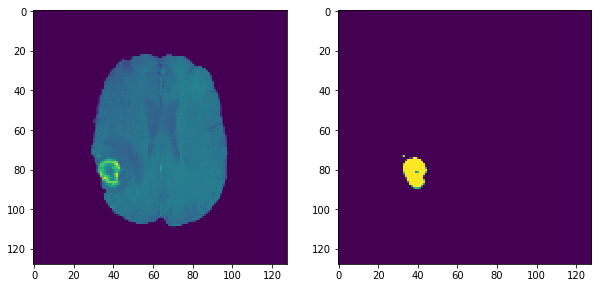

In [6]:
import random as r
i = int(r.random() * x.shape[0])
plt.figure(figsize=(10,10))
xx = x[i, 70, :, :, 0]
yy = y[i, 70, :, :, 0]
plt.subplot(121)
plt.imshow(xx)
plt.subplot(122)
plt.imshow(yy)
plt.show()

## 4 Training

In [7]:
from keras.models import Input, Model
from keras.layers import Conv3D, MaxPooling3D, UpSampling3D, Concatenate
from keras.optimizers import Adam

inputs = Input(x.shape[1:])

conv1 = Conv3D(16, 3, activation="elu", padding="same")(inputs)
pool1 = MaxPooling3D()(conv1)

conv2 = Conv3D(16, 3, activation='elu', padding='same')(pool1)
pool2 = MaxPooling3D()(conv2)

conv3 = Conv3D(16, 3, activation='elu', padding='same')(pool2)
pool3 = MaxPooling3D()(conv3)

conv4 = Conv3D(16, 3, activation='elu', padding='same')(pool3)
pool4 = MaxPooling3D()(conv4)

conv5 = Conv3D(16, 3, activation='elu', padding='same')(pool4)

up6 = UpSampling3D()(conv5)
up6 = Concatenate(axis=4)([up6, conv4])
conv6 = Conv3D(16, 3, activation='elu', padding='same')(up6)

up7 = UpSampling3D()(conv6)
up7 = Concatenate(axis=4)([up7, conv3])
conv7 = Conv3D(16, 3, activation='elu', padding='same')(up7)

up8 = UpSampling3D()(conv7)
up8 = Concatenate(axis=4)([up8, conv2])
conv8 = Conv3D(16, 3, activation='elu', padding='same')(up8)

up9 = UpSampling3D()(conv8)
up9 = Concatenate(axis=4)([up9, conv1])
conv9 = Conv3D(16, 3, activation='elu', padding='same')(up9)

conv10 = Conv3D(1, 1, activation='sigmoid')(conv9)

model = Model(inputs=inputs, outputs=conv10)

model.compile(optimizer=Adam(lr=0.0001), loss=f1_loss)

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 128, 128, 1)  0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 128, 128, 128, 16) 448       
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 64, 64, 64, 16)    0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 64, 64, 64, 16)    6928      
_________________________________________________________________
max_pooling3d_2 (MaxPooling3 (None, 32, 32, 32, 16)    0         
_________________________________________________________________
conv3d_3 (Conv3D)            (None, 32, 32, 32, 16)    6928      
_________________________________________________________________
max_pooling3d_3 (MaxPooling3 (None, 16, 16, 16, 16)    0         
__________

In [8]:
model.fit(x, y, validation_split=0.2, epochs=2, batch_size=1)

Train on 176 samples, validate on 44 samples
Epoch 1/2
  1/176 [..............................] - ETA: 27200s - loss: -0.0081

KeyboardInterrupt: 